# Google Drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from src.detector import crop_coin
import pandas as pd
from src.utils import *
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
# from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

In [9]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Image                    module      <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
KEYWORD                  str         Sztandar 1930
MARCINIAK                str         marciniak
MARCINIAK_DATASET_PATH   str         ../data/marciniak/sztandar_1930
NGC_grading              dict        n=16
NIEMCZYK                 str         niemczyk
NIEMCZYK_DATASET_PATH    str         ../data/niemczyk/sztandar_1930
ROOT_PATH                str         ..
adj_grade_pattern        str         [12345L][+-]?(/[12345L][+-]?)?
aligned_coins_path       function    <function <lambda> at 0x123b23280>
basic_grading            dict        n=16
calculate_sizes          function    <function calculate_sizes at 0x124c5a670>
clear_output             function    <function clear_output at 0x102c728b0>
companies                list        n=3
company_grade_pattern    str         (GCN|NGC|PCGS) (UNC|PF|MS|AU|XF|VF)

# Data exploration

In [22]:
def calculate_sizes(root, csv_path):
    names = [name for name in os.listdir(root) if name.split(".")[-1] == "jpg"]
    df = pd.DataFrame({"name": names, "size": None})

    pbar = tqdm(total=len(df))
    for i, row in df.iterrows():
      row["size"] = Image.open(root + "/" + row["name"]).size[0]
      pbar.update(1)
    df.to_csv(csv_path, index=None)
    pbar.close()

calculate_sizes(aligned_coins_path(NIEMCZYK_DATASET_PATH), size_aligned_path(NIEMCZYK_DATASET_PATH))
calculate_sizes(aligned_coins_path(MARCINIAK_DATASET_PATH), size_aligned_path(MARCINIAK_DATASET_PATH))

100%|██████████| 271/271 [00:00<00:00, 935.49it/s]


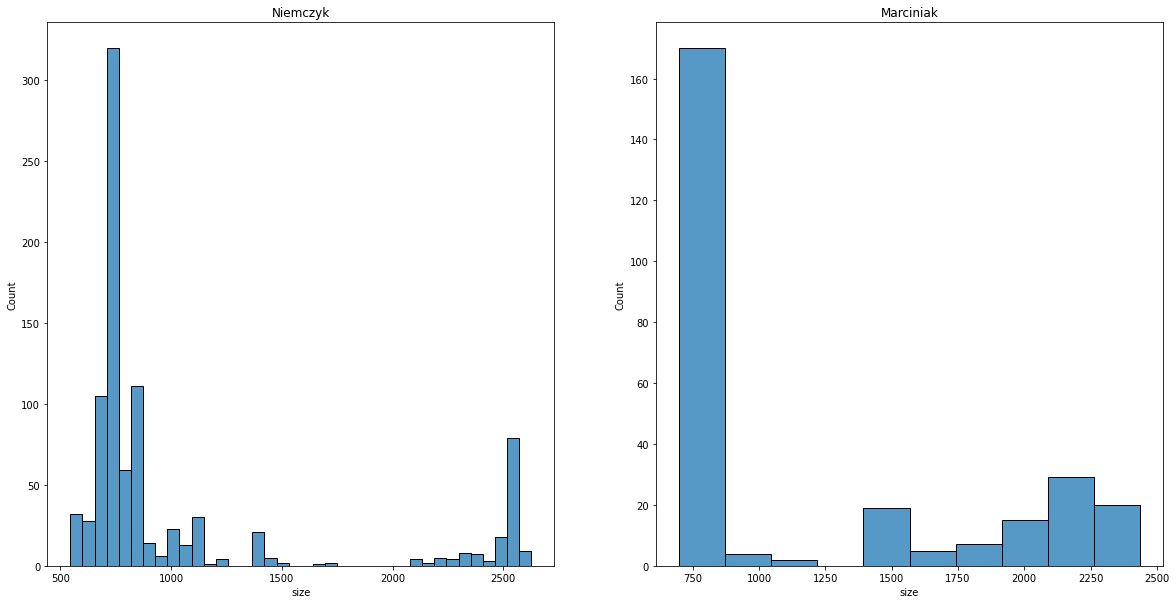

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, ds_path in enumerate([NIEMCZYK_DATASET_PATH, MARCINIAK_DATASET_PATH]):
  df = pd.read_csv(size_aligned_path(ds_path))
  sns.histplot(df["size"], ax=ax[i])

ax[0].set_title("Niemczyk")
ax[1].set_title("Marciniak")
plt.show()


# Master coin

In [37]:
def generate_master_coin(root, label):
  df1 = pd.read_csv(size_aligned_path(root))
  df2 = pd.read_csv(side_path(root))
  df = df1.merge(df2, how='inner', on='name')
  df = df.sort_values(by=['size'], ascending=False)
  df = df[df["label"] == label]
  names = df["name"]
  stack = np.stack([cv2.resize(cv2.imread(aligned_coins_path(root) + "/" + name), (700,700)) for name in names[:100]])
  master_coin = np.uint8(np.mean(stack, axis=0))

  return master_coin

master_coin_1_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/1.jpg", master_coin_1_n)
master_coin_2_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/2.jpg", master_coin_2_n)
master_coin_1_m = generate_master_coin(MARCINIAK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg", master_coin_1_m)
master_coin_2_m = generate_master_coin(MARCINIAK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg", master_coin_2_m)

True

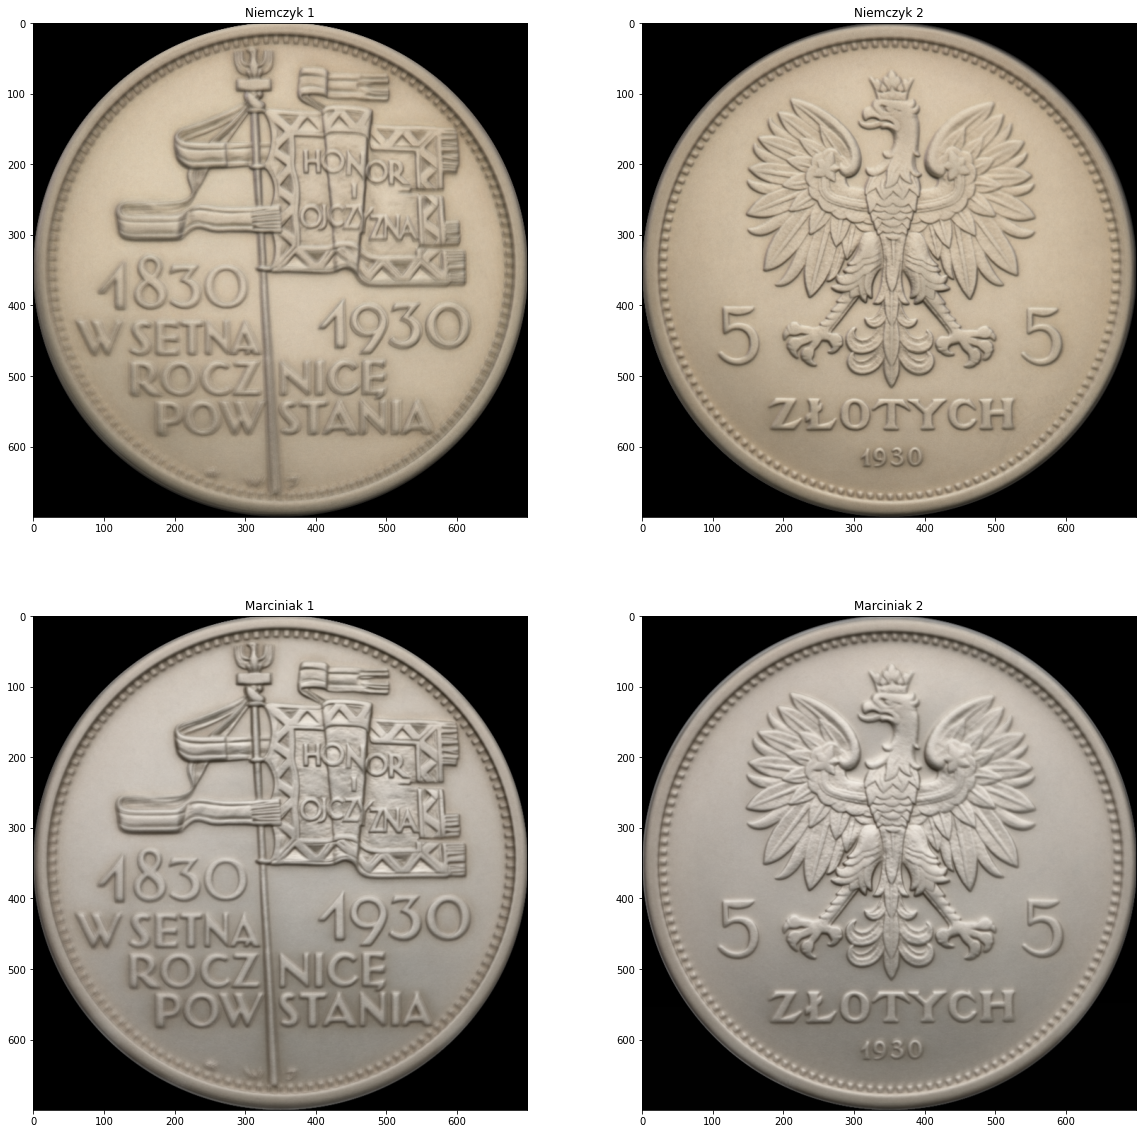

In [38]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
ax1.imshow(cv2.cvtColor(master_coin_1_n, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(master_coin_2_n, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(master_coin_2_m, cv2.COLOR_BGR2RGB))

ax1.set_title("Niemczyk 1")
ax2.set_title("Niemczyk 2")
ax3.set_title("Marciniak 1")
ax4.set_title("Marciniak 2")

plt.show()

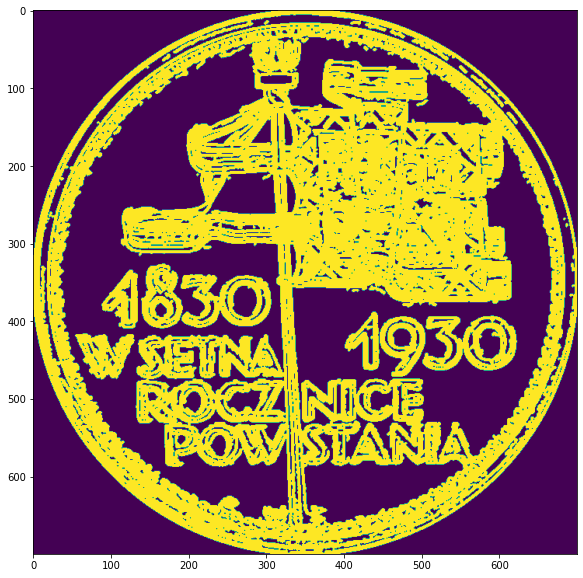

In [39]:
  im = cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2GRAY)
  im = cv2.Canny(im, 0.1*255, 0.2*255)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
  im = cv2.dilate(im, kernel ,iterations = 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)
  
  plt.figure(figsize=(10,10))
  plt.imshow(im)

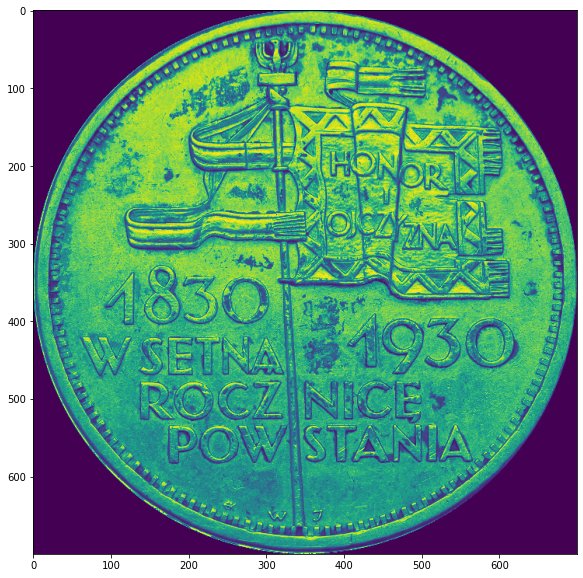

In [41]:
test_im = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_1.jpg')
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
test_im = cv2.resize(test_im, (700,700))
# test_im = cv2.Canny(test_im, 0.6*255, 0.8*255)
test_im = test_im - im

plt.figure(figsize=(10,10))
plt.imshow(test_im)